In [1]:
#######################################
# Auto-reload development imports
#######################################

%load_ext autoreload
%autoreload 2

In [2]:
#######################################
#imports
#######################################

import os, sys
dir0 = os.path.split(os.getcwd())[0]
if dir0 not in sys.path:
    sys.path.append(dir0)
from mountainlab_pytools import mlproc as mlp

In [18]:
#######################################
# LARI login
#######################################

lari_id='fdb573a66f50' ## lari_ccblin008
#lari_id='19b775bb238f' ## lari_g5ub
#lari_id='133898b2b079' ## lari_jm
#lari_id='cb48a51bf9e5' ## lari_dub
#lari_id='' # local computer

mlp.lariLogin(lari_id,lari_passcode=None)

Enter processing passcode for lari node fdb573a66f50


 ···


In [19]:
#######################################
# Import sorting pipelines
#######################################

from mountainsort4_1_0 import sort_dataset as ms4_sort_dataset
from ironclust import sort_dataset as ironclust_sort_dataset

In [20]:
#######################################
# Create output directory
#######################################

output_base_dir=os.getcwd()+'/output'
#import shutil
#if os.path.exists(output_base_dir):
#    shutil.rmtree(output_base_dir)
if not os.path.exists(output_base_dir):
    print('Creating directory: {}'.format(output_base_dir))
    os.mkdir(output_base_dir)
else:
    print('Directory already exists: {}'.format(output_base_dir))

Directory already exists: /home/magland/src/ml/mountainsort_examples/spikeforest/output


In [21]:
#######################################
# Set up datasets
#######################################

datasets=[]
datasets.append({
    "id":"synth_tetrode_30min",
    "raw_path":"kbucket://b5ecdf1474c5/datasets/synth_datasets/datasets/synth_tetrode_30min"
});
datasets.append({
    "id":"synth_tetrode_120min",
    "raw_path":"kbucket://b5ecdf1474c5/datasets/synth_datasets/datasets/synth_tetrode_120min"
});
datasets.append({
    "id":"synth_16ch_30min",
    "raw_path":"kbucket://b5ecdf1474c5/datasets/synth_datasets/datasets/synth_16ch_30min"
});

datasets=[datasets[0]]

print('Number of datasets: {}'.format(len(datasets)))

Number of datasets: 1


In [22]:
#######################################
# Set up algorithms
#######################################

verbose=''

def ms4_thr3(dataset_dir,output_dir):
    ms4_sort_dataset(
        dataset_dir=dataset_dir,
        output_dir=output_dir,
        adjacency_radius=-1,
        detect_threshold=3,
        opts={'verbose':verbose}
    )
    
def ms4_thr4(dataset_dir,output_dir):
    ms4_sort_dataset(
        dataset_dir=dataset_dir,
        output_dir=output_dir,
        adjacency_radius=-1,
        detect_threshold=4,
        opts={'verbose':verbose}
    )
    
def ironclust(dataset_dir,output_dir):
    ironclust_sort_dataset(
        dataset_dir=dataset_dir,
        output_dir=output_dir
    )

algs=[]
algs.append({"name":"ms4_thr3","run":ms4_thr3})
algs.append({"name":"ms4_thr4","run":ms4_thr4})
algs.append({"name":"ironclust","run":ironclust})

algs=[algs[2]]
#algs=[algs[0]]
#algs=[algs[0],algs[1]]
#algs=[algs[0],algs[2]]

print('Number of algorithms: {}'.format(len(algs)))

Number of algorithms: 1


In [23]:
#######################################
# Collect runs (algorithm/dataset pairs)
#######################################

runs=[]
for i_ds in range(len(datasets)):
    for i_alg in range(len(algs)):
        runs.append({"dataset":datasets[i_ds],"alg":algs[i_alg]})
#runs=[runs[0]]

print('Number of runs: {}'.format(len(runs)))

Number of runs: 1


In [26]:
#######################################
# INITIALIZE THE PIPELINE (Note: for now it is important to have the job monitor in a separate cell) -- See https://github.com/AaronWatters/jp_proxy_widget/issues/2
#######################################

Pipeline=mlp.initPipeline()

JSProxyWidget(status='Not yet rendered')

In [27]:
#######################################
# RUN THE PIPELINE
#######################################
from spikeforest import add_run_to_pipeline
with Pipeline:
    for run in runs:
        add_run_to_pipeline(run, output_base_dir)

:::: Applying ironclust to synth_tetrode_30min


Output()

Finished pipeline.


In [28]:
from spikeforest import get_run_output
import json

output={}
output['datasets']=datasets
output['runs']=[]
for run in runs:
    out=get_run_output(run)
    output['runs'].append(out)
with open('spikeforest_output.json','w') as f:
    json.dump(output, f)
    
from IPython.display import JSON
display(JSON(output,expanded=True))

<IPython.core.display.JSON object>

In [29]:
import vdom

import json
import subprocess
def loadPrvObject(fname):
    if not os.path.isfile(fname):
        if not fname.endswith('.prv'):
            if os.path.isfile(fname+'.prv'):
                fname=fname+'.prv'
            else:
                raise Exception('File not found: {}'.format(fname))
        else:
            raise Exception('File not found: {}'.format(fname))
    if fname.endswith('.prv'):
        with open(fname) as f:
             return json.load(f)
    else:
        str=subprocess.check_output(['ml-prv-stat', fname]).decode('utf-8').strip()
        return json.loads(str)

def kbpath(fname):
    obj=loadPrvObject(fname)
    return 'sha1://'+obj['original_checksum']
    
def show_result(run):
    DS=run['dataset']
    ALG=run['alg']
    run_title=ALG['name']+' : '+DS['id']
    dsdir=DS['raw_path']
    dsid=DS['id']
    algname=ALG['name']
    output_dir=output_base_dir+'/'+dsid+'--'+algname
    
    display(vdom.h3(run_title))
    
    url='https://ephys-viz.herokuapp.com/?view=dataset&dataset={}'.format(dsdir)
    display(vdom.a('Dataset',href=url,target='_blank'))
    
    url='https://ephys-viz.herokuapp.com/?view=dataset&dataset={}&firings={}'.format(dsdir,kbpath(output_dir+'/firings.mda'))
    display(vdom.a('Sorting result',href=url,target='_blank'))
    
    url='https://ephys-viz.herokuapp.com/?view=templates&templates={}'.format(kbpath(output_dir+'/summary/templates.mda'))
    display(vdom.a('Templates',href=url,target='_blank'))
    
    url='https://ephys-viz.herokuapp.com/?view=sort_comparison&comparison={}'.format(kbpath(output_dir+'/validation/compare_ground_truth.json'))
    display(vdom.a('Comparison with ground truth',href=url,target='_blank'))
    
for run in runs:
    show_result(run)

<h3 />

<a />

<a />

<a />

<a />

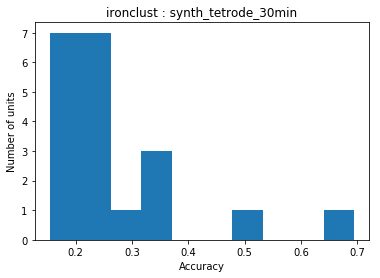

In [30]:
from matplotlib import pyplot as plt
for ii in range(len(runs)):
    run=runs[ii]
    DS=run['dataset']
    ALG=run['alg']
    run_title=ALG['name']+' : '+DS['id']
    dsdir=DS['raw_path']
    dsid=DS['id']
    algname=ALG['name']
    output_dir=output_base_dir+'/'+dsid+'--'+algname
    fname=output_dir+'/validation/compare_ground_truth.json'
    
    with open(fname,'r') as f:
        obj=json.load(f)
    true_units=obj['true_units']
    units=[]
    for k in true_units:
        units.append(true_units[k])
    accuracies=[unit['accuracy'] for unit in units]
    plt.hist(accuracies)
    plt.title(run_title)
    plt.xlabel('Accuracy')
    plt.ylabel('Number of units')
    plt.show()